In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# 일별 국채 CDS 가격 (2001~2025)
cds_df = pd.read_csv('../dataset/KOREA CDS 2001-2025.csv')
cds_df['date'] = pd.to_datetime(cds_df['date'].astype(str).str.replace(' ', ''))
cds_df = cds_df.sort_values('date')
cds_prep = cds_df.copy()
cds_prep['date'] = pd.to_datetime(cds_prep['date'])
cds_prep = cds_prep[['date', 'parspread']] 
cds_prep['short'] = cds_prep['parspread'].rolling(5, min_periods=1).mean() # 5일 CDS 평균치
cds_prep['long']  = cds_prep['parspread'].rolling(252, min_periods=60).mean() # 252일 CDS 평균치
cds_prep['cds_gap'] = cds_prep['short'] - cds_prep['long'] # 5일평균 - 252일평균 (최근 변화량)
cds_prep = cds_prep.dropna()

# 검색량 데이터
df_trend_sum = pd.read_csv("../dataset/trend_sum.csv")
df_trend_sum['date'] = pd.to_datetime(df_trend_sum['date'])
# Risk Reversal 25 (2014~2025)
df_rr = pd.read_excel('../dataset/3M.xlsx') 
df_rr = df_rr.iloc[:, :2]
df_rr.columns = ['date', 'RR']

# 환율 데이터 (2014~2025)
df_exchange = yf.download('KRW=X', start='2014-01-01', end='2025-12-31')

# yfinance MultiIndex 컬럼 처리 (에러 방지)
if isinstance(df_exchange.columns, pd.MultiIndex):
    df_exchange.columns = df_exchange.columns.get_level_values(0)

df_exchange = df_exchange.reset_index()
if 'Date' in df_exchange.columns:
    df_exchange = df_exchange.rename(columns={'Date': 'date'})
df_exchange['date'] = pd.to_datetime(df_exchange['date']).dt.tz_localize(None)
df_exchange = df_exchange[['date', 'Close']].rename(columns={'Close': 'exchange_rate'})

# 2. 데이터 병합
merged_df = cds_prep.copy()
merged_df = pd.merge(merged_df, df_trend_sum, on='date', how='inner') 
merged_df = pd.merge(merged_df, df_exchange, on='date', how='inner')
merged_df = pd.merge(merged_df,df_rr[['date','RR']],on='date',how='inner')
# 날짜순 정렬 및 인덱스 설정
merged_df = merged_df.sort_values('date').set_index('date')


# 3. 정규화 (0~1 Scaling) 함수 정의
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# 각 지표 정규화 적용 
merged_df['cds_norm'] = min_max_normalize(merged_df['cds_gap'])
merged_df['RR_norm'] = min_max_normalize(merged_df['RR'])
merged_df['trend_sum_rank'] = merged_df['trend_sum'].rank(pct=True)
merged_df.head()

[*********************100%***********************]  1 of 1 completed


,parspread,short,long,cds_gap,trend_sum,minmax_trend_sum,rank_trend_sum,exchange_rate,RR,cds_norm,RR_norm,trend_sum_rank
date,,,,,,,,,,,,
2016-01-01,0.004848,0.004859,0.005083,-0.000224,4.159759,0.018238,0.039411,1174.109985,0.8,0.329707,0.349794,0.000385
2016-01-04,0.005020,0.004886,0.005079,-0.000193,13.348222,0.108707,0.535657,1174.109985,1.087,0.335864,0.397037,0.088145
2016-01-05,0.004969,0.004904,0.005074,-0.000171,13.897416,0.114429,0.584047,1187.359985,0.65,0.340270,0.325103,0.103926
2016-01-06,0.005193,0.004976,0.005070,-0.000095,14.946825,0.124695,0.645515,1188.719971,0.788,0.355429,0.347819,0.131640
2016-01-07,0.005516,0.005109,0.005068,0.000042,17.191959,0.146988,0.746363,1198.739990,0.875,0.382603,0.36214,0.186682


2016~ CDS 데이터 Plot

코로나 시기를 제외하면 장기 우하향 추세를 보임

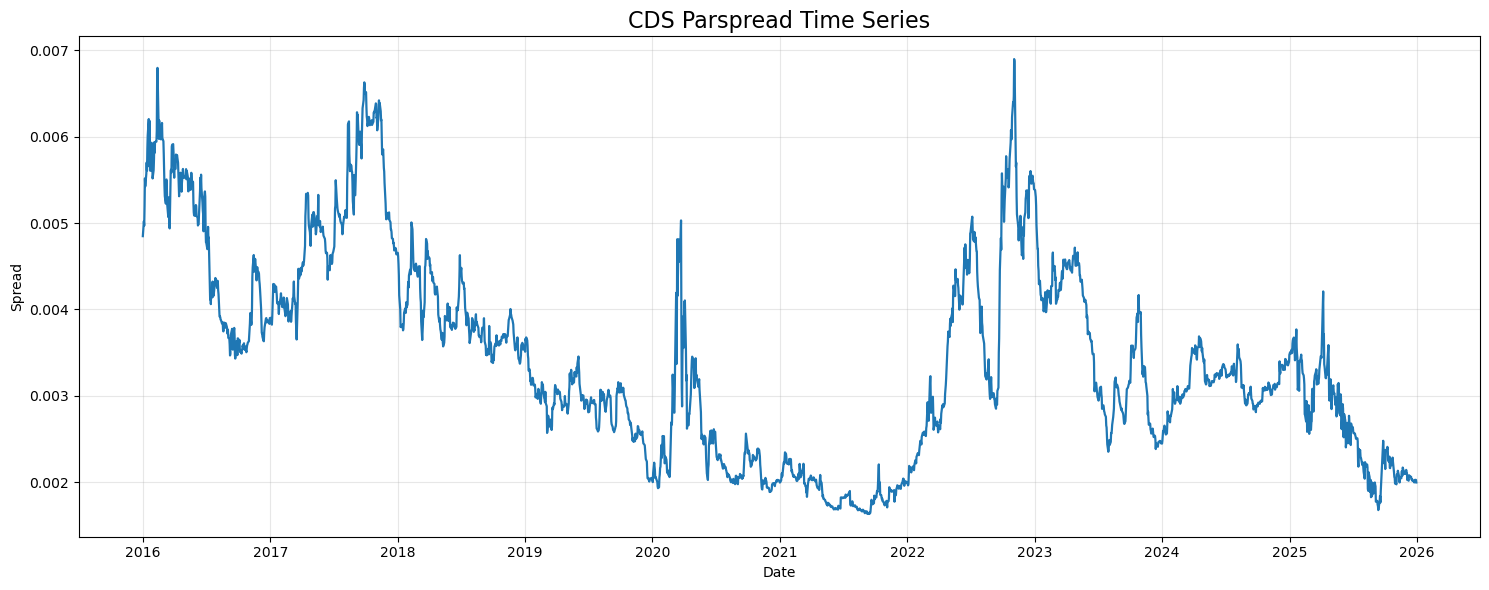

In [3]:
import matplotlib.pyplot as plt

series = merged_df['parspread']

plt.figure(figsize=(15,6))
plt.plot(series.index, series.values, linewidth=1.6)

plt.title('CDS Parspread Time Series', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Spread')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Fear Index = 검색량 데이터(정규화) + 국채 5년물 CDS(정규화) + Risk Reversal 3M(정규화)

In [4]:
import numpy as np
merged_df['fear_index'] = merged_df['rank_trend_sum'] + merged_df['cds_norm'] + merged_df['RR_norm']
merged_df['fear_index'] = merged_df['fear_index'].astype(np.float32)

Fear Index 와 환율 변화율 간의 time-lag cross correlation 확인 (-30일~30일)

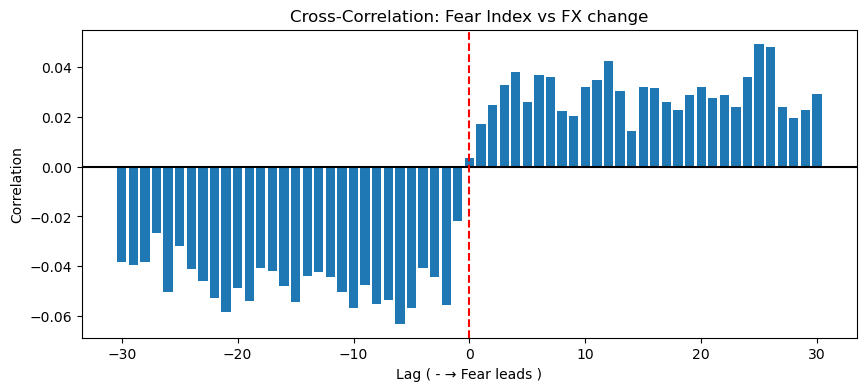

In [5]:
import numpy as np

fear = merged_df['fear_index']
rate = merged_df['exchange_rate']

# 각 날들의 전날대비 증가율 데이터
# log(USD/KRW_[t] / USD/KRW_[t-1])
rate_ret = np.log(rate / rate.shift(1))

max_lag = 30
lags = range(-max_lag, max_lag+1)
ccf = [fear.corr(rate_ret.shift(lag)) for lag in lags]
# lag = -30: 30일 후 환율 변화율과의 correlation
# lag = +30: 30일 전 환율 변화율과의 correlation

plt.figure(figsize=(10,4))
plt.bar(lags, ccf)
plt.axhline(0, color='black')
plt.axvline(0, color='red', linestyle='--')

plt.title("Cross-Correlation: Fear Index vs FX change")
plt.xlabel("Lag ( - → Fear leads )")
plt.ylabel("Correlation")
plt.show()

fear 구간을 10개로 나눠서 fear이 높아짐에 따라 향후 n일 간 변동성이 높아지는지 확인

<Axes: title={'center': 'Fear quantile vs Future 5D FX volatility'}, xlabel='fear_q'>

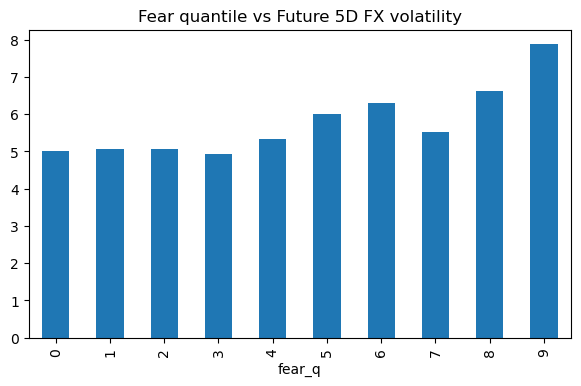

In [6]:
window = 5 # 뒤로 몇일동안 변동성을 계산할건지
merged_df['future_vol'] = rate.rolling(window).std().shift(-1 * window)

tmp = merged_df[['fear_index','future_vol']].dropna()
# 0: fear 가장 낮은 10%
# 9: fear 가장 높은 10% 
tmp['fear_q'] = pd.qcut(tmp['fear_index'], 10, labels=False)
tmp.groupby('fear_q')['future_vol'].mean()

res = tmp.groupby('fear_q')['future_vol'].mean()

res.plot(kind='bar', figsize=(7,4), title='Fear quantile vs Future 5D FX volatility')

fear 구간을 10개로 나눠서 fear이 높아짐에 따라 이전 n일 역시 변동성이 높았는지 확인

<Axes: title={'center': 'Fear quantile vs Past 5D FX volatility'}, xlabel='fear_q'>

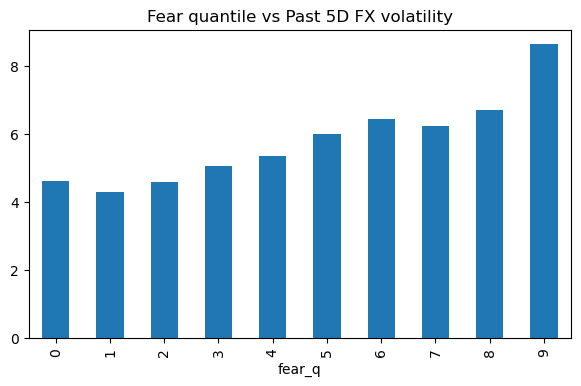

In [7]:
window = 5 # 뒤로 몇일동안 변동성을 계산할건지
merged_df['past_vol'] = rate.rolling(window).std()

tmp = merged_df[['fear_index','past_vol']].dropna()
# 0: fear 가장 낮은 10%
# 9: fear 가장 높은 10% 
tmp['fear_q'] = pd.qcut(tmp['fear_index'], 10, labels=False)
tmp.groupby('fear_q')['past_vol'].mean()

res = tmp.groupby('fear_q')['past_vol'].mean()

res.plot(kind='bar', figsize=(7,4), title='Fear quantile vs Past 5D FX volatility')

환차익 Simulation: 공포지수를 역발상 지표로 활용, 특정 임계값 밑으로 내려가면 공포가 지나치게 낮다 판단해 원화를 달러로 환전 / 특정 임계값 위로 올라가면 공포가 지나치게 높다 판단해 달러를 원화로 환전.

{'final_krw': np.float64(1380910.6967873743), 'CAGR_est': np.float64(0.031800511626713934), 'MDD': -0.12273489115193081, 'num_trades': 9, 'buy_th': 1.0, 'sell_th': 2.0, 'fee_bps_each_trade': 10.0, 'signal_uses_next_day': True, 'start': Timestamp('2016-01-01 00:00:00'), 'end': Timestamp('2025-12-30 00:00:00')}


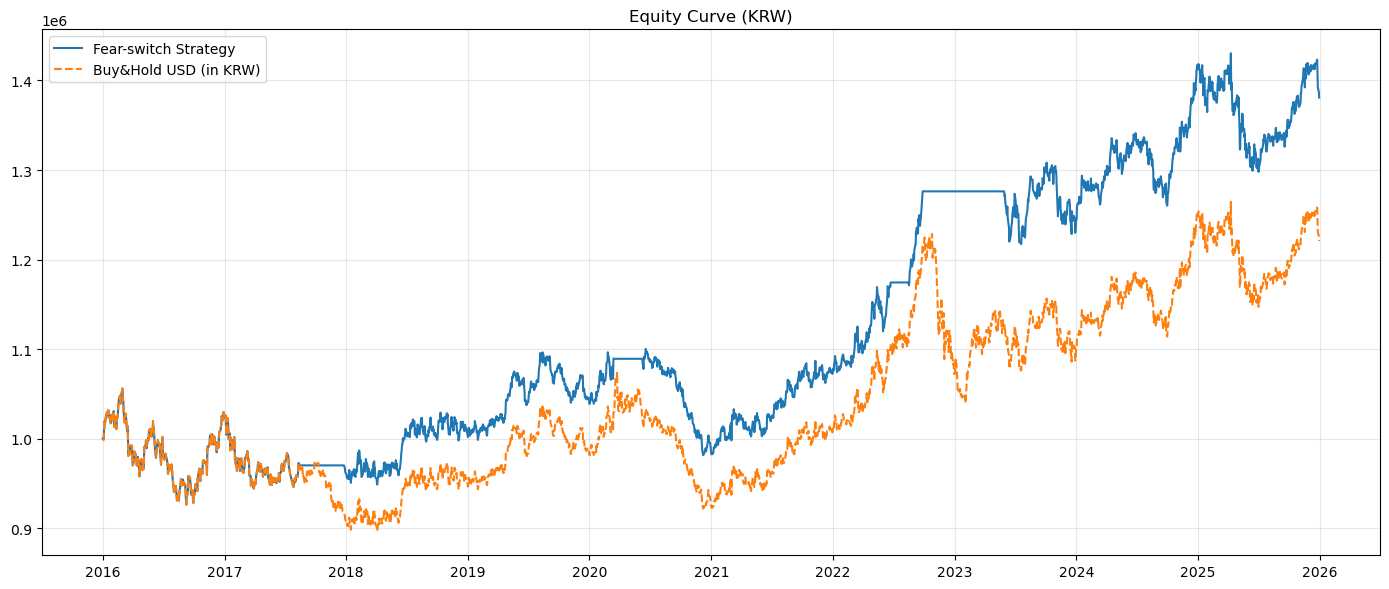

In [18]:
def backtest_fx_fear_switch(
    merged_df: pd.DataFrame,
    fear_col: str = "fear_index",
    rate_col: str = "exchange_rate",
    buy_th: float = 1.0,   # fear < buy_th => KRW -> USD
    sell_th: float = 3.0,  # fear > sell_th => USD -> KRW
    initial_krw: float = 1_000_000.0,
    fee_bps: float = 10.0, # 환전 비용(왕복이 아니라 '한 번 환전'당) 10bp=0.10%
    use_next_day: bool = True
):
    df = merged_df[[fear_col, rate_col]].copy().dropna()
    df = df.sort_index()

    # 신호를 다음날 적용(치팅 방지)
    fear_sig = df[fear_col].shift(1) if use_next_day else df[fear_col]

    # 목표 포지션: 0=KRW, 1=USD
    # fear < buy_th => USD 보유
    # fear > sell_th => KRW 보유
    target = pd.Series(np.nan, index=df.index, dtype=float)
    target[fear_sig < buy_th] = 1.0
    target[fear_sig > sell_th] = 0.0
    target = target.ffill().fillna(0.0)  # 처음엔 KRW부터 시작

    # 거래 발생(포지션 변경) 체크
    trade = target.diff().fillna(0.0) != 0

    fee = fee_bps / 10_000.0  # bps -> 비율
    rate = df[rate_col].astype(float)

    # 자산 상태
    krw = initial_krw
    usd = 0.0

    equity_krw = []
    pos_hist = []
    trade_hist = []

    for t in range(len(df)):
        date = df.index[t]
        r = rate.iloc[t]
        desired = int(target.iloc[t])

        # 포지션 변경 시 환전
        if trade.iloc[t]:
            if desired == 1:
                # KRW -> USD (수수료 적용)
                usd = (krw * (1 - fee)) / r
                krw = 0.0
            else:
                # USD -> KRW
                krw = (usd * (1 - fee)) * r
                usd = 0.0

        # 평가액(항상 KRW로 평가)
        value = krw + usd * r
        equity_krw.append(value)
        pos_hist.append(desired)
        trade_hist.append(bool(trade.iloc[t]))

    out = df.copy()
    out["position"] = pos_hist  # 0=KRW, 1=USD
    out["trade"] = trade_hist
    out["equity_krw"] = equity_krw
    out["ret"] = out["equity_krw"].pct_change().fillna(0.0)

    # 벤치마크 1: 계속 KRW (현금)
    out["bh_krw"] = initial_krw

    # 벤치마크 2: 처음에 USD로 환전해서 계속 보유
    usd0 = (initial_krw * (1 - fee)) / rate.iloc[0]
    out["bh_usd_in_krw"] = usd0 * rate

    def max_drawdown(x: pd.Series) -> float:
        cummax = x.cummax()
        dd = x / cummax - 1
        return dd.min()

    n_days = len(out)
    years = n_days / 252.0  # 거래일 가정
    final_val = out["equity_krw"].iloc[-1]
    cagr = (final_val / initial_krw) ** (1 / years) - 1 if years > 0 else np.nan
    mdd = max_drawdown(out["equity_krw"])
    trades = out["trade"].sum()

    summary = {
        "final_krw": final_val,
        "CAGR_est": cagr,
        "MDD": mdd,
        "num_trades": int(trades),
        "buy_th": buy_th,
        "sell_th": sell_th,
        "fee_bps_each_trade": fee_bps,
        "signal_uses_next_day": use_next_day,
        "start": out.index.min(),
        "end": out.index.max(),
    }

    return out, summary

bt, summary = backtest_fx_fear_switch(
    merged_df,
    buy_th=1.0,
    sell_th=2.0,
    initial_krw=1_000_000,
    fee_bps=10.0,       
    use_next_day=True   
)

print(summary)

plt.figure(figsize=(14,6))
plt.plot(bt.index, bt["equity_krw"], label="Fear-switch Strategy")
plt.plot(bt.index, bt["bh_usd_in_krw"], linestyle="--", label="Buy&Hold USD (in KRW)")
plt.title("Equity Curve (KRW)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


구성요소 별 Plot

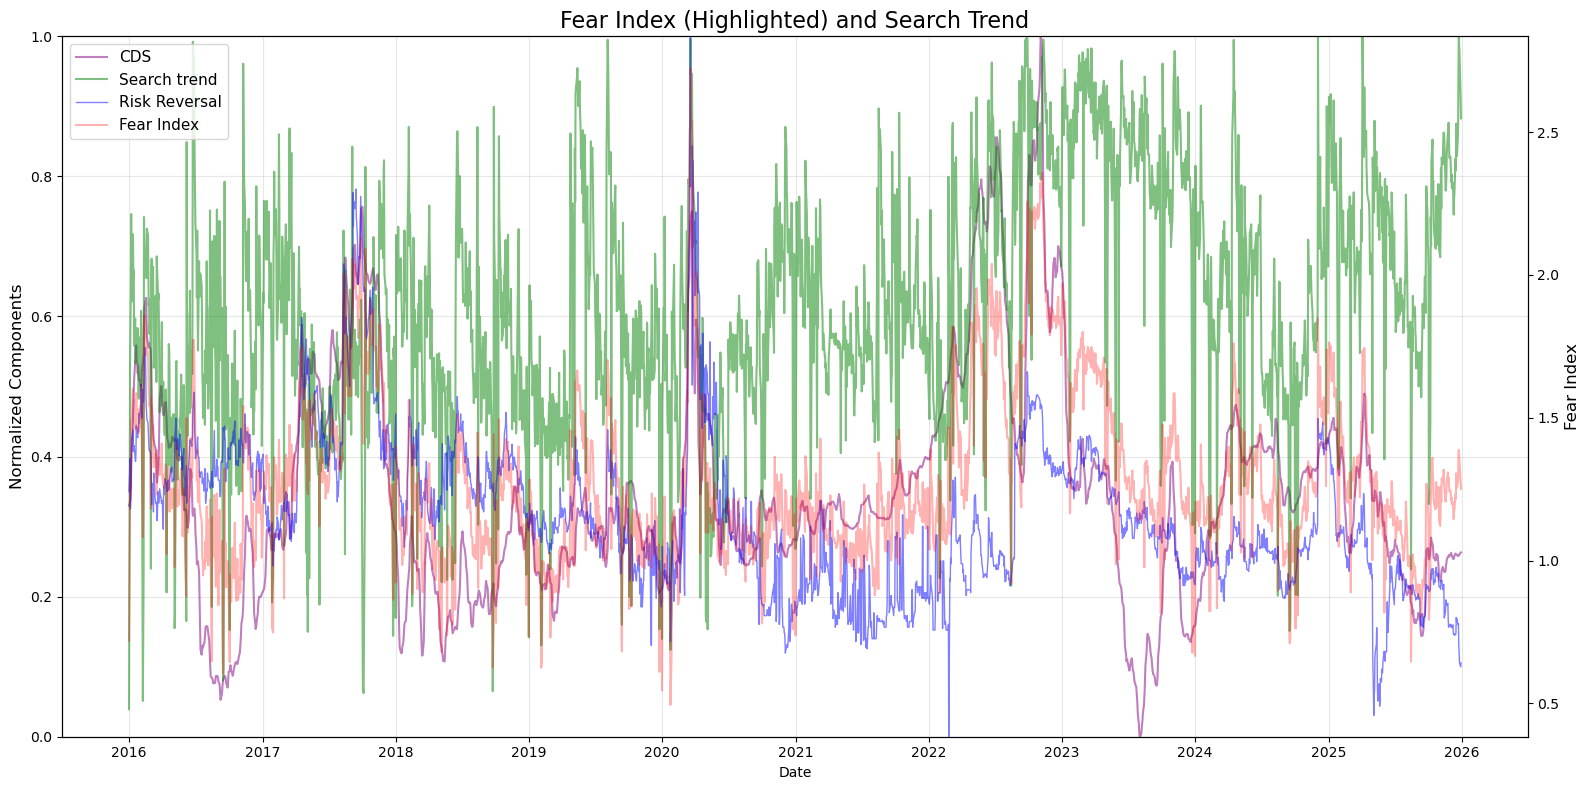

In [22]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Components', fontsize=12)

l1, = ax1.plot(
    merged_df.index, merged_df['cds_norm'],
    label='CDS', color='purple', alpha=0.5
)

l2, = ax1.plot(
    merged_df.index, merged_df['rank_trend_sum'],
    color='green', alpha=0.5, label='Search trend'
)

l3, = ax1.plot(
    merged_df.index, merged_df['RR_norm'],
    color='blue', alpha=0.5, linewidth=1, label='Risk Reversal'
)

ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Fear Index', fontsize=12)

l4, = ax2.plot(
    merged_df.index, merged_df['fear_index'],
    label='Fear Index', color='red', alpha=0.3
)

lines = [l1, l2, l3, l4]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.title('Fear Index (Highlighted) and Search Trend', fontsize=16)
plt.tight_layout()
plt.show()
